<a href="https://colab.research.google.com/github/Narendrakumar-Suresh/FER/blob/main/FER_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up Kaggle to import data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nandydev","key":"4adb653edf0e679cd72b784a98422e84"}'}

## Setting up directory

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d msambare/fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0


In [ ]:
import zipfile

with zipfile.ZipFile("fer2013.zip", "r") as zip_ref:
    zip_ref.extractall("fer2013")


## importing necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms

### Setting up hyperparameters and CUDA

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters
num_epochs=30
batch_size=64
learning_rate=5e-4

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = datasets.ImageFolder(root="fer2013/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = datasets.ImageFolder(root="fer2013/test", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.bn1 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3_2d = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4_2d = nn.BatchNorm2d(512)

        dummy_input = torch.zeros(1, 1, 48, 48)
        x = self.pool(F.gelu(self.bn1(self.conv1(dummy_input))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool(F.gelu(self.bn3_2d(self.conv3(x))))
        x = self.pool(F.gelu(self.bn4_2d(self.conv4(x))))
        self.flattened_size = x.view(1, -1).size(1)

        self.l1 = nn.Linear(self.flattened_size, 128)
        self.bn1d_1 = nn.BatchNorm1d(128)

        self.l2 = nn.Linear(128, 128)
        self.bn1d_2 = nn.BatchNorm1d(128)

        self.l3 = nn.Linear(128, 128)

        self.l4 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool(F.gelu(self.bn3_2d(self.conv3(x))))
        x = self.pool(F.gelu(self.bn4_2d(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1d_1(self.l1(x)))
        x = F.relu(self.bn1d_2(self.l2(x)))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x


In [ ]:
model=CNN().to(device)
criterion=nn.CrossEntropyLoss(label_smoothing=0.01)
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
n_steps=len(train_loader)

## Training loop

In [ ]:
loss_tracker = []

for i in range(num_epochs):
    model.train()
    running_loss = 0.0

    for j, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        output = model(image)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (j + 1) % 400 == 0:
            print(f'Epoch [{i+1}/{num_epochs}], Step [{j+1}/{n_steps}], Loss: {loss.item():.4f}')

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)
    loss_tracker.append(avg_loss)

Epoch [1/30], Step [200/449], Loss: 1.3328
Epoch [1/30], Step [400/449], Loss: 1.3476
Epoch [2/30], Step [200/449], Loss: 1.1185
Epoch [2/30], Step [400/449], Loss: 1.2535
Epoch [3/30], Step [200/449], Loss: 1.0921
Epoch [3/30], Step [400/449], Loss: 1.1725
Epoch [4/30], Step [200/449], Loss: 1.2140
Epoch [4/30], Step [400/449], Loss: 1.2479
Epoch [5/30], Step [200/449], Loss: 1.1866
Epoch [5/30], Step [400/449], Loss: 1.0010
Epoch [6/30], Step [200/449], Loss: 1.1077
Epoch [6/30], Step [400/449], Loss: 0.8370
Epoch [7/30], Step [200/449], Loss: 1.0116
Epoch [7/30], Step [400/449], Loss: 0.9091
Epoch [8/30], Step [200/449], Loss: 0.7636
Epoch [8/30], Step [400/449], Loss: 0.9714
Epoch [9/30], Step [200/449], Loss: 0.8371
Epoch [9/30], Step [400/449], Loss: 0.7240
Epoch [10/30], Step [200/449], Loss: 0.8512
Epoch [10/30], Step [400/449], Loss: 0.9030
Epoch [11/30], Step [200/449], Loss: 1.0182
Epoch [11/30], Step [400/449], Loss: 0.8301
Epoch [12/30], Step [200/449], Loss: 0.7156
Epoch 

### Graph to visualize the losses

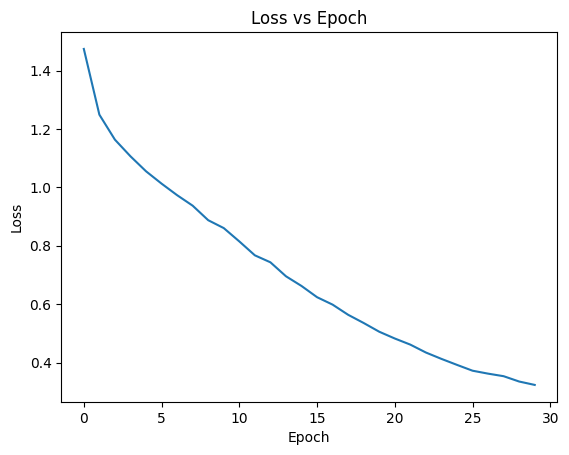

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_tracker)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for _ in range(7)]
  n_samples_correct = [0 for _ in range(7)]

  for j,(image,label) in enumerate(val_loader):
    image=image.to(device)
    label=label.to(device)

    output=model(image)
    prob=F.softmax(output,dim=1)
    _,predicted=torch.max(prob,1)

    n_samples += label.size(0)
    n_correct += (predicted == label).sum().item()

    for i in range(len(label)):
            true_label = label[i].item()
            pred_label = predicted[i].item()

            if true_label == pred_label:
                n_class_correct[true_label] += 1
            n_samples_correct[true_label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy is {acc}%')

Accuracy is 62.51044859292282%


In [ ]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for i in range(7):
    acc = 100.0 * n_class_correct[i] / n_samples_correct[i] if n_samples_correct[i] > 0 else 0
    print(f'Accuracy of {classes[i]}: {acc:.2f}%')

Accuracy of Angry: 55.01%
Accuracy of Disgust: 49.55%
Accuracy of Fear: 44.43%
Accuracy of Happy: 81.34%
Accuracy of Sad: 52.55%
Accuracy of Surprise: 56.70%
Accuracy of Neutral: 78.46%
